In [1]:
import numpy as np
from numpy import mean,std
from random import randint
import pandas as pd

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D,add,BatchNormalization,Activation,AveragePooling2D,Dropout
from keras.layers import LSTM,Bidirectional
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from keras.optimizers import SGD,Adam

from keras.models import load_model,Model
from keras.backend import placeholder
from keras.initializers import glorot_uniform
from keras.utils import multi_gpu_model
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import os
plt.rcParams["figure.figsize"] = (16,8)
import plotly
from plotly.express import line,scatter
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scipy.io as sio

data = sio.loadmat('UDDS.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

UDDS_data = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
UDDS_data.columns = ['Strom','Spannung','Temperatur','Kapazitat']

data = sio.loadmat('US06.mat')  
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

US06_data = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
US06_data.columns = ['Strom','Spannung','Temperatur','Kapazitat']

In [3]:
SoC = [1]
for i in range(1,len(UDDS_data)):

    SoC.append(SoC[i-1]+0.1*UDDS_data['Strom'].iloc[i-1]/(2.9*3600))


UDDS_data['SoC'] = SoC

SoC = [1]
for i in range(1,len(US06_data)):

    SoC.append(SoC[i-1]+0.1*UDDS_data['Strom'].iloc[i-1]/(2.9*3600))


US06_data['SoC'] = SoC

In [5]:
UDDS_data.to_csv('UDDS_data.csv',)
US06_data.to_csv('US06_data.csv')

In [7]:
UDDS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224187 entries, 0 to 224186
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Strom       224187 non-null  float64
 1   Spannung    224187 non-null  float64
 2   Temperatur  224187 non-null  float64
 3   Kapazitat   224187 non-null  float64
 4   SoC         224187 non-null  float64
dtypes: float64(5)
memory usage: 8.6 MB


In [10]:
UDDS_data.pop('Kapazitat')

0        -0.00000
1        -0.00000
2        -0.00000
3        -0.00000
4        -0.00001
           ...   
224182   -2.70149
224183   -2.70149
224184   -2.70149
224185   -2.70149
224186   -2.70149
Name: Kapazitat, Length: 224187, dtype: float64

In [12]:
(UDDS_data.corr())

,Strom,Spannung,Temperatur,SoC
Strom,1.000000,0.184765,0.002384,0.009373
Spannung,0.184765,1.000000,-0.599931,0.978800
Temperatur,0.002384,-0.599931,1.000000,-0.602756
SoC,0.009373,0.978800,-0.602756,1.000000


In [13]:
n_i = 1 # timesteps
features = len(UDDS_data.columns)-1
n_o = 1 #prediction time step

In [14]:
#series to supervised series data

def series2supervised(df,n_i,n_o):

    n_vars = df.shape[1]

    cols, names = list(),list()

    for i in range(n_i,0,-1):

        cols.append(df.shift(i))

        names += [('var%d(t-%d)') %((j+1,i)) for j in range(n_vars)]

    
    for i in range(n_o):
        cols.append(df.shift(i))

    for j in range(n_vars):

        for i in range(0,n_o):

            if i== 0:
                names+=[('var%d(t)') %(j+1)]

            else:
                names +=[('var%d(t+%d)')%((j+1,i))]

    agg = pd.concat(cols,axis=1)
    agg.columns = names

    agg.dropna(inplace = True)


    return names,agg

    

In [15]:
names,data_LSTM = series2supervised(UDDS_data,n_i,n_o)

In [16]:
data_LSTM

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,-0.01062,4.18188,25.63070,1.000000,-0.04900,4.18059,25.63070,1.000000
2,-0.04900,4.18059,25.63070,1.000000,-0.06125,4.17995,25.63070,0.999999
3,-0.06125,4.17995,25.63070,0.999999,-0.06533,4.17995,25.63070,0.999999
4,-0.06533,4.17995,25.63070,0.999999,-0.06615,4.17995,25.63070,0.999998
5,-0.06615,4.17995,25.63070,0.999998,-0.06615,4.17995,25.63070,0.999998
...,...,...,...,...,...,...,...,...
224182,0.00000,3.31605,26.26957,0.069974,0.00000,3.31605,26.26957,0.069974
224183,0.00000,3.31605,26.26957,0.069974,0.00000,3.31605,26.26957,0.069974
224184,0.00000,3.31605,26.26957,0.069974,0.00000,3.31605,26.26957,0.069974
224185,0.00000,3.31605,26.26957,0.069974,0.00000,3.31605,26.25836,0.069974


In [17]:
data_x = data_LSTM[data_LSTM.columns[:n_i*features+n_o-1]]
data_y = data_LSTM[data_LSTM.columns[-n_o:]]

In [18]:
data_y

,var4(t)
1,1.000000
2,0.999999
3,0.999999
4,0.999998
5,0.999998
...,...
224182,0.069974
224183,0.069974
224184,0.069974
224185,0.069974


In [27]:
#split train and test data 

x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,shuffle= False,test_size=0.3)

In [28]:
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,shuffle=False,test_size = 0.5)

In [21]:
x_val

,var1(t-1),var2(t-1),var3(t-1)
179349,0.85586,3.54960,25.84366
179350,0.85668,3.54960,25.84366
179351,0.85586,3.54960,25.84366
179352,0.85586,3.54960,25.84366
179353,0.85586,3.54960,25.84366
...,...,...,...
201763,-0.18047,3.38539,26.26957
201764,-0.17966,3.38539,26.26957
201765,-0.21477,3.38475,26.26957
201766,-0.35686,3.37960,26.26957


In [29]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_val_scaled = scaler.fit_transform(x_val)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1,1))
y_val_scaled = scaler.fit_transform(np.array(y_val).reshape(-1,1))

In [30]:
x_train_LSTM = x_train_scaled.reshape(x_train.shape[0],n_i,features)
x_test_LSTM = x_test_scaled.reshape(x_test.shape[0],n_i,features)
x_val_LSTM = x_val_scaled.reshape(x_val.shape[0],n_i,features)

y_train_LSTM = y_train_scaled
y_test_LSTM = y_test_scaled
y_val_LSTM = y_val_scaled

In [24]:
x_train_LSTM.shape

(179348, 1, 3)

In [0]:
#convert data into LSTM data 
#def create_dataset(X, y, time_steps=1):#
    #Xs, ys = [], []
    #for i in range(len(X) - time_steps):
        #v = X.iloc[i:(i + time_steps)].values
        #Xs.append(v)        
        #ys.append(y.iloc[i + time_steps])
    #return np.array(Xs), np.array(ys)

2453/2453 [==============================] - 23s 9ms/step - loss: 0.1445 - val_loss: 0.1565
Epoch 34/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1398 - val_loss: 0.1524
Epoch 35/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1352 - val_loss: 0.1484
Epoch 36/50
2453/2453 [==============================] - 23s 10ms/step - loss: 0.1308 - val_loss: 0.1446
Epoch 37/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1266 - val_loss: 0.1410
Epoch 38/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1225 - val_loss: 0.1375
Epoch 39/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1186 - val_loss: 0.1341
Epoch 40/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1148 - val_loss: 0.1309
Epoch 41/50
2453/2453 [==============================] - 23s 9ms/step - loss: 0.1113 - val_loss: 0.1279
Epoch 42/50
2453/2453 [==============================] - 23s 9ms/step - los

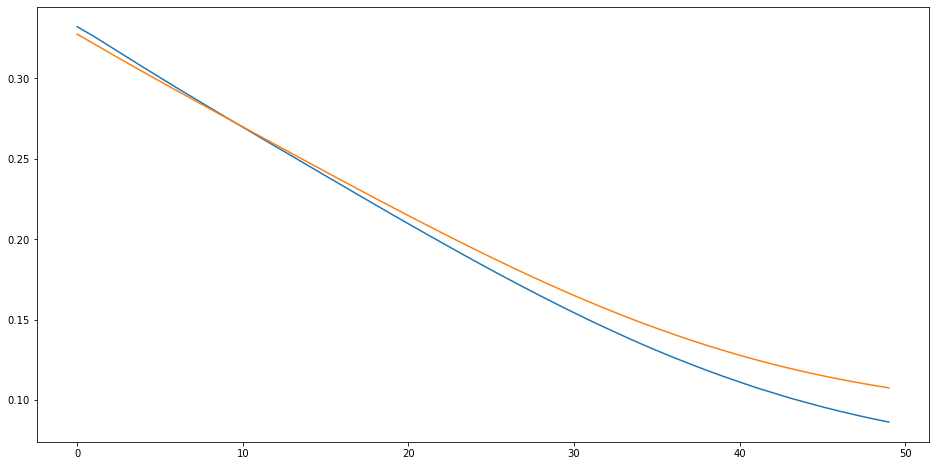

In [32]:
def LSTM_model(X):
    
    np.random.seed(1)

    X_i = Input(shape = (X.shape[1],X.shape[2]))
    
    X = Bidirectional(LSTM(256,activation = 'relu',kernel_initializer = 'glorot_uniform',return_sequences=True,input_shape=(X.shape[1:])))(X_i)
    

    X = Bidirectional(LSTM(128,activation = 'relu',kernel_initializer = 'glorot_uniform',return_sequences =True))(X)
    
    X = Dropout(0.3)(X)
    
    X = Dense(50,activation='tanh',name='layer3')(X)
    
    X = Dense(10,activation='tanh',name='layer4')(X)
    
    X = Dense(1,activation= 'relu',name='layer5')(X)

    model = Model(inputs = X_i,outputs = X)
    
    return model


model = LSTM_model(x_train_LSTM)
model.summary()
#plot_model(model, show_shapes=True, to_file='LSTM_SoC.png')
np.random.seed(1)
model.compile(optimizer = Adam(lr=0.0000001),loss = 'mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
history = model.fit(x_train_LSTM,y_train_LSTM,batch_size = 64, epochs = 50,validation_data = (x_val_LSTM,y_val_LSTM),verbose = 1,shuffle = False,callbacks=[es])
plt.plot(history.history['loss'],label ='train')
plt.plot(history.history['val_loss'],label = 'val loss')

model.save_weights("model_16.12.h5")

In [79]:
predictions_train = model.predict(x_train_LSTM)
R2 = r2_score(y_train_LSTM,predictions_train.reshape(-1,1))
print(R2)


predictions_val = model.predict(x_val_LSTM);
R2 = r2_score(y_val_LSTM,predictions_val.reshape(-1,1))
print(R2)

predictions_test = model.predict(x_test_LSTM);
R2 = r2_score(y_test_LSTM,predictions_test.reshape(-1,1))
print(R2)

0.6985839443978632
0.3146604738189831
0.47358407669671887


In [27]:
test_sample= scaler.fit_transform(np.array([4.2,4.32,11]).reshape(1,-1)).reshape(1,1,3)
test_op= model.predict(test_sample)

In [56]:
pred_train = scaler.inverse_transform(predictions_train)
y_act_train = scaler.inverse_transform(y_train_LSTM)

pred_val = scaler.inverse_transform(predictions_val)
y_act_val = scaler.inverse_transform(y_val_LSTM)

pred_test = scaler.inverse_transform(predictions_test)
y_act_test = scaler.inverse_transform(y_test_LSTM)

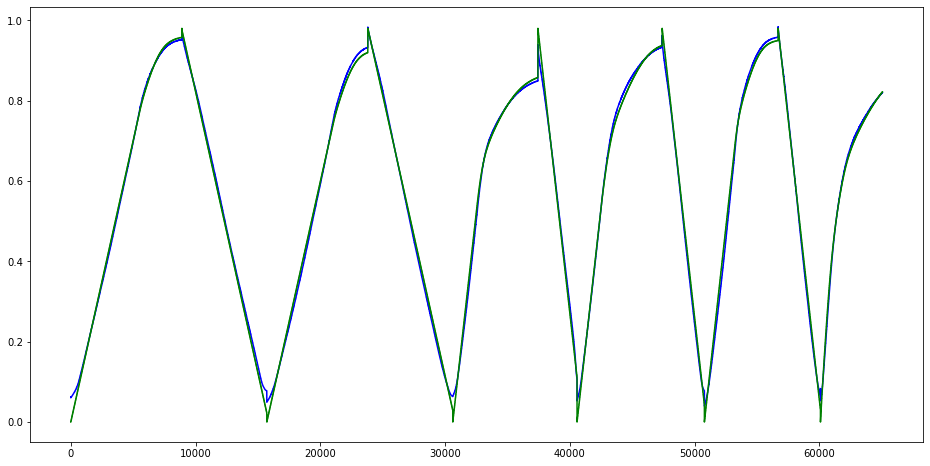

In [57]:
plt.plot(pred_train,'-b')
plt.plot(y_act_train,'-g')

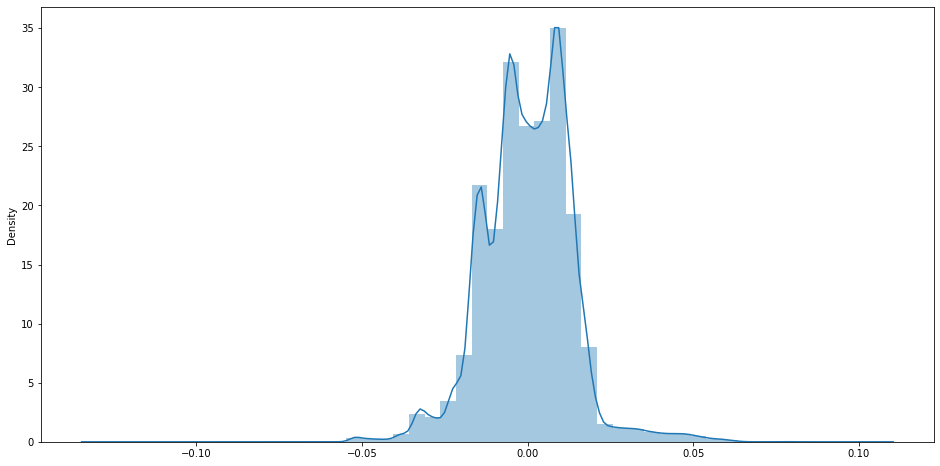

In [58]:
sns.distplot(pred_train-y_act_train)

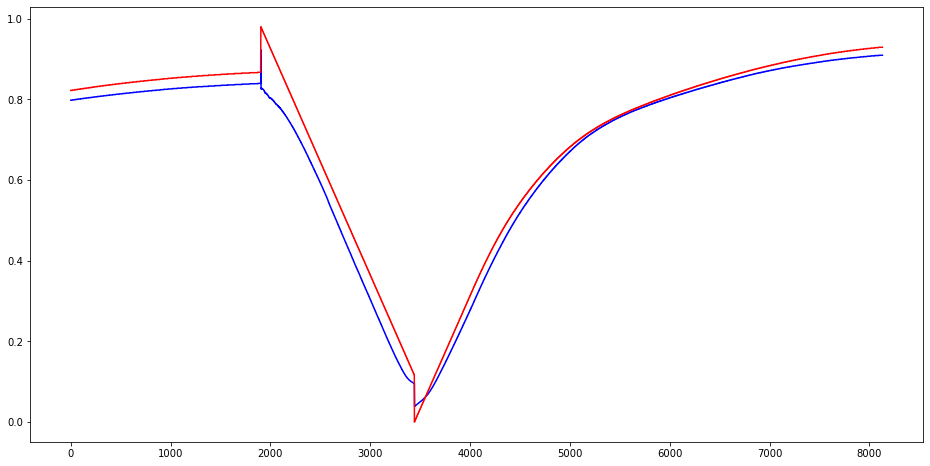

In [59]:
plt.plot(pred_val,'-b')
plt.plot(y_act_val,'-r')

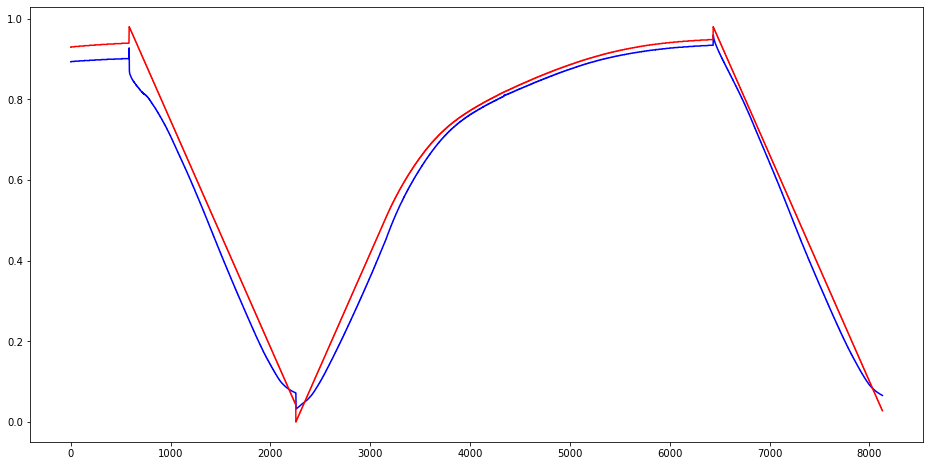

In [60]:
plt.plot(pred_test,'-b')
plt.plot(y_act_test,'-r')

In [59]:
df2 = pd.concat((pd.DataFrame(y_act_train),pd.DataFrame(pred_train)),axis =1)
df2.columns = ['train_act','train_pred']

In [60]:
df3 = pd.concat((pd.DataFrame(y_act_test),pd.DataFrame(pred_test)),axis =1)
df3.columns = ['test_act','test_pred']

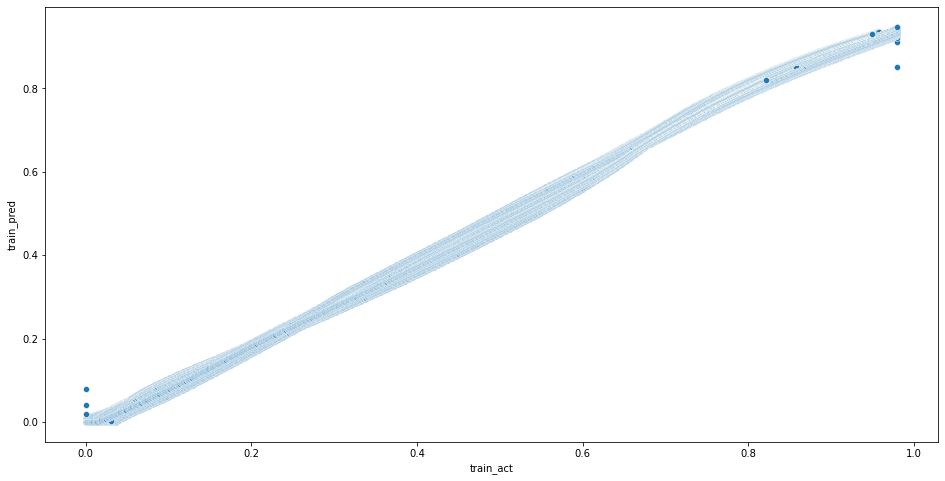

In [61]:
sns.scatterplot(x='train_act',y='train_pred',data = df2)

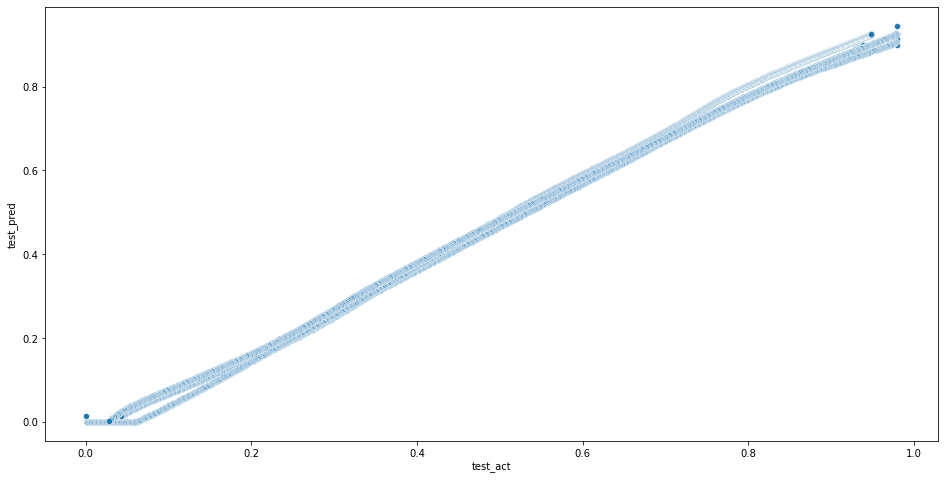

In [66]:
sns.scatterplot(x='test_act',y='test_pred',data = df3,palette='bright',alpha=1)

In [63]:
line(df3['test_act']-df3['test_pred'])

Unsupported

In [0]:
# DNN feedforward network 
def DNN(X):
    np.random.seed(1)
    model1 = Sequential()

    model1.add(Dense(3,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros',input_dim=X.shape[1]))

    model1.add(Dense(512,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))

    model1.add(Dense(256,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))

    model1.add(Dense(100,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))

    model1.add(Dense(10,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))
    
    model1.add(Dense(1,activation='linear',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))
    
    model1.compile(loss='mse', optimizer=Adam(lr=0.000001))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
    
    history = model1.fit(x_train_scaled,y_train_scaled,batch_size = 32, epochs = 100,validation_data = (x_test_scaled,y_test_scaled),verbose = 1,shuffle = False,callbacks=[es])
    
    plt.plot(history.history['loss'],label ='train')
    plt.plot(history.history['val_loss'],label = 'val loss')
    
    
    return model1


In [0]:
model1 = DNN(x_train_scaled)
model1.save_weights("model.h5")

In [0]:
predictions_train = model1.predict(x_train_scaled);
R2 = r2_score(y_train_scaled,predictions_train)
print(R2)

predictions_test = model1.predict(x_test_scaled);
R2 = r2_score(y_test_scaled,predictions_test)
print(R2)

pred_train = scaler.inverse_transform(predictions_train)
y_act_train = scaler.inverse_transform(y_train_scaled)

pred_test = scaler.inverse_transform(predictions_test)
y_act_test = scaler.inverse_transform(y_test_scaled)


                         
plt.plot(pred_train)
plt.plot(y_act_train)

In [0]:
plt.plot(pred_test)
plt.plot(y_act_test)